# Katrina Input Files

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import os
import matplotlib.pyplot as plt
import adcircpy
from adcircpy.outputs import (
    Maxele,
    MaximumElevationTimes,
    Fort63,
    Fort61,
    Minpr,
    Maxwvel,
    Maxvel,
)
from sithom.plot import plot_defaults
from src.constants import KAT_EX_PATH, NO_BBOX

plot_defaults()

/Users/simon/new-orleans/env/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/Users/simon/new-orleans/env/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [11]:
for file_tuple in [
    ("fort.217", "fort.218"),
    ("fort.221", "fort.222"),
    ("fort.223", "fort.224"),
]:
    with open(os.path.join(KAT_EX_PATH, file_tuple[0])) as file:
        len_pressure = len([x for x in file])
        print("Pressure [mb]", len_pressure)

    with open(os.path.join(KAT_EX_PATH, file_tuple[1])) as file:
        len_wsp = len([x for x in file])
        print("Windspeeds [m s**-1]", len_wsp)

    print("\n")

    print("len_pressure / len_wsp :", len_pressure / len_wsp)

    print("\n")

Pressure [mb] 19377
Windspeeds [m s**-1] 38697


len_pressure / len_wsp : 0.5007364912008683


Pressure [mb] 70057
Windspeeds [m s**-1] 140057


len_pressure / len_wsp : 0.5002034885796497


Pressure [mb] 19377
Windspeeds [m s**-1] 38697


len_pressure / len_wsp : 0.5007364912008683




In [147]:
from typing import List
import numpy as np
import xarray as xr


def read_data_line(line: str) -> List[float]:
    # 4 decimal point figures
    return [float(x) for x in line.strip("\n").split(" ") if x != ""]


def read_coord_line(line, names) -> dict:
    """
    Process line.

    Example::
        >>> names = ["iLat", "iLong", "DX", "DY", "SWLat", "SWLon", "DT"]
        >>> line = "iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250000"
        >>> read_coord_line(line, names)
        {'iLat': 46.0,
         'iLong': 60.0,
         'DX': 0.05,
         'DY': 0.05,
         'SWLat': 28.6,
         'SWLon': -90.28,
         'DT': 200508250000.0}
    """
    result_dict = {}

    for i, name in enumerate(names):
        line = line.strip(name + "=")
        if i < len(names) - 1:
            int_l = line.split(names[i + 1] + "=")
            result_dict[name] = float(int_l[0])
            line = int_l[1]
        else:
            result_dict[name] = float(int_l[1])

    return result_dict


def read_windspeeds(windspeed_path: str) -> xr.Dataset:
    with open(windspeed_path) as file:

        wsp_list = [x for x in file]
        wsp_lol = []

        len_wsp = len(wsp_list)
        print("len pressure", len_wsp)

        print(wsp_list[0])
        print(wsp_list[1])
        print(wsp_list[2])
        print(read_line(wsp_list[2]))

        wsp_lol.append([])
        for i in range(2, len_wsp):
            if wsp_list[i].startswith(" "):
                wsp_lol[-1].append(read_line(wsp_list[i]))
            else:
                print(wsp_list[i])
                wsp_lol.append([])

        names = ["iLat", "iLong", "DX", "DY", "SWLat", "SWLon", "DT"]
        coords = read_coord_line(wsp_list[1], names)
        date_list = [
            read_coord_line(x, names)["DT"] for x in wsp_list if x.startswith("i")
        ]
        print(date_list)
        print(len(date_list))
        lats = np.array(
            [coords["SWLat"] + coords["DY"] * i for i in range(int(coords["iLat"]))]
        )
        lons = np.array(
            [coords["SWLon"] + coords["DX"] * i for i in range(int(coords["iLong"]))]
        )
        data = np.array(wsp_lol).reshape(len(date_list), 2, len(lats), len(lons))
        return xr.Dataset(
            data_vars=dict(
                uvel=(["time", "lat", "lon"], data[:, 0, :, :]),
                vvel=(["time", "lat", "lon"], data[:, 1, :, :]),
            ),
            coords=dict(
                lon=(["lon"], lons),
                lat=(["lat"], lats),
                time=date_list,
            ),
            attrs=dict(description="Weather related data."),
        )


def read_pressures(pressure_path: str) -> xr.DataArray:
    with open(pressure_path) as file:

        pressure_list = [x for x in file]
        pressure_lol = []

        len_pressure = len(pressure_list)
        print("len pressure", len_pressure)

        print(pressure_list[0])
        print(pressure_list[1])
        print(pressure_list[2])
        print(read_line(pressure_list[2]))

        names = ["iLat", "iLong", "DX", "DY", "SWLat", "SWLon", "DT"]
        coords = read_coord_line(pressure_list[1], names)

        pressure_lol.append([])
        for i in range(2, len_pressure):
            if pressure_list[i].startswith(" "):
                pressure_lol[-1].append(read_line(pressure_list[i]))
            else:
                print(pressure_list[i])
                pressure_lol.append([])

        date_list = [
            read_coord_line(x, names)["DT"] for x in pressure_list if x.startswith("i")
        ]
        lats = np.array(
            [coords["SWLat"] + coords["DY"] * i for i in range(int(coords["iLat"]))]
        )
        lons = np.array(
            [coords["SWLon"] + coords["DX"] * i for i in range(int(coords["iLong"]))]
        )
        print(date_list)
        print(len(date_list))

        # 56 diff list - one for each timestep.
        return xr.DataArray(
            data=np.array(pressure_lol).reshape(len(date_list), len(lats), len(lons)),
            dims=["time", "lat", "lon"],
            coords=dict(
                lon=(["lon"], lons),
                lat=(["lat"], lats),
                time=date_list,
            ),
            attrs=dict(
                description="Pressure",
                units="mb",
            ),
        )

In [148]:
ds_218 = read_windspeeds(os.path.join(KAT_EX_PATH, "fort.218"))
ds_222 = read_windspeeds(os.path.join(KAT_EX_PATH, "fort.222"))
ds_224 = read_windspeeds(os.path.join(KAT_EX_PATH, "fort.224"))

len pressure 38697
Oceanweather WIN/PRE Format                            2005082500     2005083121

iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250000

   -4.4665   -4.3980   -4.3604   -4.2985   -4.2514   -4.2389   -4.2370   -4.2362

[-4.4665, -4.398, -4.3604, -4.2985, -4.2514, -4.2389, -4.237, -4.2362]
iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250300

iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250600

iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250900

iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508251200

iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508251500

iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508251800

iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508252100

iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508260000

iLat=  4

iLat= 100iLong= 100DX=0.2500DY=0.2500SWLat=17.00000SWLon=-99.0000DT=200508311800

iLat= 100iLong= 100DX=0.2500DY=0.2500SWLat=17.00000SWLon=-99.0000DT=200508312100

[200508250000.0, 200508250300.0, 200508250600.0, 200508250900.0, 200508251200.0, 200508251500.0, 200508251800.0, 200508252100.0, 200508260000.0, 200508260300.0, 200508260600.0, 200508260900.0, 200508261200.0, 200508261500.0, 200508261800.0, 200508262100.0, 200508270000.0, 200508270300.0, 200508270600.0, 200508270900.0, 200508271200.0, 200508271500.0, 200508271800.0, 200508272100.0, 200508280000.0, 200508280300.0, 200508280600.0, 200508280900.0, 200508281200.0, 200508281500.0, 200508281800.0, 200508282100.0, 200508290000.0, 200508290300.0, 200508290600.0, 200508290900.0, 200508291200.0, 200508291500.0, 200508291800.0, 200508292100.0, 200508300000.0, 200508300300.0, 200508300600.0, 200508300900.0, 200508301200.0, 200508301500.0, 200508301800.0, 200508302100.0, 200508310000.0, 200508310300.0, 200508310600.0, 200508310900.0, 200

In [141]:
ds_218

<xarray.Dataset>
Dimensions:  (time: 56, lat: 46, lon: 60)
Coordinates:
  * lon      (lon) float64 -90.28 -90.23 -90.18 -90.13 ... -87.43 -87.38 -87.33
  * lat      (lat) float64 28.6 28.65 28.7 28.75 28.8 ... 30.7 30.75 30.8 30.85
  * time     (time) float64 2.005e+11 2.005e+11 ... 2.005e+11 2.005e+11
Data variables:
    uvel     (time, lat, lon) float64 -4.466 -4.398 -4.36 ... 1.478 1.458 1.458
    vvel     (time, lat, lon) float64 1.448 1.448 1.46 ... -0.5733 -0.4672
Attributes:
    description:  Weather related data.

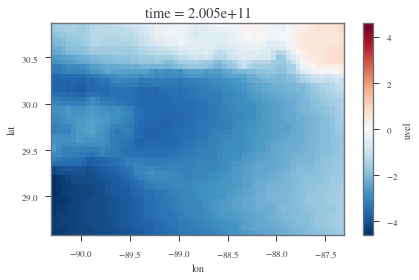

In [143]:
ds_218.uvel.isel(time=0).plot()

In [127]:
da_217

<xarray.DataArray (time: 56, lat: 46, lon: 60)>
array([[[1012.9691, 1012.9689, 1012.9665, ..., 1013.0684, 1013.0934,
         1013.113 ],
        [1012.9589, 1012.9589, 1012.9595, ..., 1013.0624, 1013.083 ,
         1013.105 ],
        [1012.9246, 1012.9269, 1012.927 , ..., 1013.0318, 1013.0557,
         1013.0816],
        ...,
        [1012.512 , 1012.5382, 1012.5593, ..., 1012.954 , 1012.9482,
         1012.9564],
        [1012.4918, 1012.5223, 1012.5358, ..., 1013.0113, 1012.9951,
         1012.9843],
        [1012.4749, 1012.5042, 1012.5211, ..., 1013.0164, 1013.0107,
         1013.0079]],

       [[1015.4116, 1015.3963, 1015.3859, ..., 1014.4594, 1014.4515,
         1014.4393],
        [1015.4094, 1015.3944, 1015.3838, ..., 1014.451 , 1014.4401,
         1014.4329],
        [1015.404 , 1015.3874, 1015.3753, ..., 1014.4131, 1014.4096,
         1014.4018],
...
        [1009.1655, 1009.1841, 1009.2115, ..., 1010.5015, 1010.5364,
         1010.554 ],
        [1009.1476, 1009.1575, 1009.1848, ..., 1010.4577, 1010.4814,
         1010.512 ],
        [1009.1405, 1009.1542, 1009.1757, ..., 1010.4362, 1010.4623,
         1010.4967]],

       [[1011.8702, 1011.8791, 1011.8808, ..., 1012.3428, 1012.3844,
         1012.4125],
        [1011.845 , 1011.8537, 1011.8629, ..., 1012.3291, 1012.3604,
         1012.3947],
        [1011.761 , 1011.771 , 1011.7763, ..., 1012.2734, 1012.3006,
         1012.3263],
        ...,
        [1008.5499, 1008.5969, 1008.6563, ..., 1009.9096, 1009.9064,
         1009.895 ],
        [1008.5179, 1008.5613, 1008.6144, ..., 1009.9203, 1009.9056,
         1009.886 ],
        [1008.5014, 1008.5495, 1008.6066, ..., 1009.9139, 1009.9043,
         1009.895 ]]])
Coordinates:
  * lon      (lon) float64 -90.28 -90.23 -90.18 -90.13 ... -87.43 -87.38 -87.33
  * lat      (lat) float64 28.6 28.65 28.7 28.75 28.8 ... 30.7 30.75 30.8 30.85
  * time     (time) float64 2.005e+11 2.005e+11 ... 2.005e+11 2.005e+11
Attributes:
    description:  Pressure
    units:        mb

In [ ]:
da_217 = read_pressures(os.path.join(KAT_EX_PATH, "fort.217"))
da_221 = read_pressures(os.path.join(KAT_EX_PATH, "fort.221"))
da_223 = read_pressures(os.path.join(KAT_EX_PATH, "fort.223"))

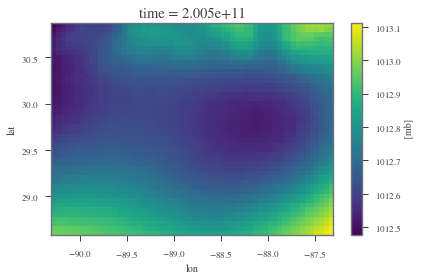

In [117]:
da_217.isel(time=0).plot()

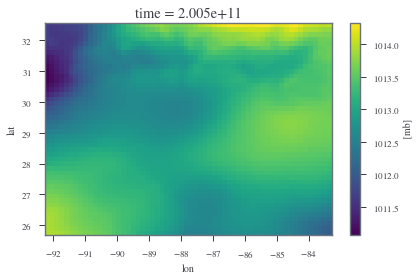

In [116]:
da_223.isel(time=0).plot()

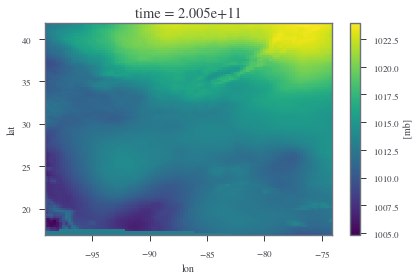

In [115]:
da_221.isel(time=0).plot()

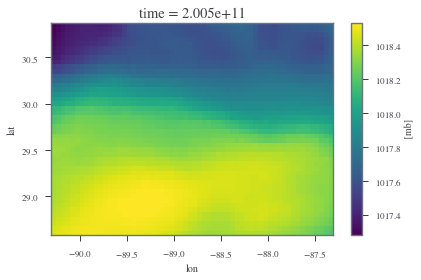

In [109]:
da_217.isel(time=5).plot()

In [ ]:
da = xr.DataArray(
    data=temperature,
    dims=["time", "lon", "lat"],
    coords=dict(
        lon=(["lon"], lon),
        lat=(["lat"], lat),
        time=time,
    ),
    attrs=dict(
        description="Pressure",
        units="degC",
    ),
)

In [57]:
print(npa.shape)
npa[1, :, :].ravel()

(56, 345, 8)


array([1015.4116, 1015.3963, 1015.3859, ..., 1014.8865, 1014.8607,
       1014.8319])

In [36]:
19377 * 345

6685065

In [41]:
npa[4, :, :]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [59]:
npa[1, :, :].ravel().shape

(2760,)

In [66]:
iLat = 46
iLong = 60
DX = 0.0500
DY = 0.0500
SWLat = 28.60000
SWLon = -90.2800
DT = "200508270300"
lat = np.array([SWLat + DY * i for i in range(iLat)])
lon = np.array([SWLon + DX * i for i in range(iLong)])
print(lat)
print(lon)

[28.6  28.65 28.7  28.75 28.8  28.85 28.9  28.95 29.   29.05 29.1  29.15
 29.2  29.25 29.3  29.35 29.4  29.45 29.5  29.55 29.6  29.65 29.7  29.75
 29.8  29.85 29.9  29.95 30.   30.05 30.1  30.15 30.2  30.25 30.3  30.35
 30.4  30.45 30.5  30.55 30.6  30.65 30.7  30.75 30.8  30.85]
[-90.28 -90.23 -90.18 -90.13 -90.08 -90.03 -89.98 -89.93 -89.88 -89.83
 -89.78 -89.73 -89.68 -89.63 -89.58 -89.53 -89.48 -89.43 -89.38 -89.33
 -89.28 -89.23 -89.18 -89.13 -89.08 -89.03 -88.98 -88.93 -88.88 -88.83
 -88.78 -88.73 -88.68 -88.63 -88.58 -88.53 -88.48 -88.43 -88.38 -88.33
 -88.28 -88.23 -88.18 -88.13 -88.08 -88.03 -87.98 -87.93 -87.88 -87.83
 -87.78 -87.73 -87.68 -87.63 -87.58 -87.53 -87.48 -87.43 -87.38 -87.33]


In [67]:
print(len(lat) * len(lon))

2760


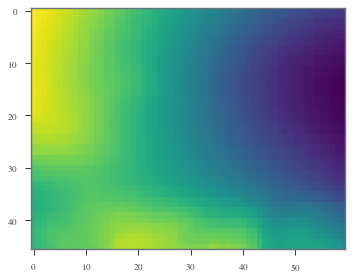

In [72]:
plt.imshow(npa[1].reshape(len(lat), len(lon)))

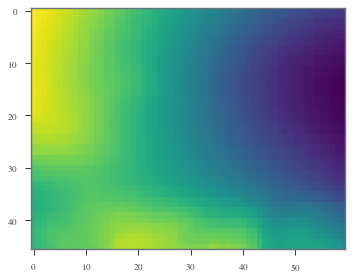

In [73]:
plt.imshow(npa.reshape(56, len(lat), len(lon))[1, :, :])

In [ ]:
xr.DataArray()

In [74]:
"iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250000".split(
    "="
)

['iLat',
 '  46iLong',
 '  60DX',
 '0.0500DY',
 '0.0500SWLat',
 '28.60000SWLon',
 '-90.2800DT',
 '200508250000']

In [78]:
"iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250000".strip(
    "iLat="
).split(
    "iLong="
)

['  46', '  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250000']

In [93]:
def process_line(line, names) -> dict:
    """
    Process line.

    Example::
        >>> names = ["iLat", "iLong", "DX", "DY", "SWLat", "SWLon", "DT"]
        >>> line = "iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250000"
        >>> process_line(line, names)
        {'iLat': 46.0,
         'iLong': 60.0,
         'DX': 0.05,
         'DY': 0.05,
         'SWLat': 28.6,
         'SWLon': -90.28,
         'DT': 200508250000.0}
    """

    line = "iLat=  46iLong=  60DX=0.0500DY=0.0500SWLat=28.60000SWLon=-90.2800DT=200508250000"
    result_dict = {}

    for i, name in enumerate(names):
        line = line.strip(name + "=")
        if i < len(names) - 1:
            int_l = line.split(names[i + 1] + "=")
            result_dict[name] = float(int_l[0])
            line = int_l[1]
        else:
            result_dict[name] = float(int_l[1])

    return result_dict

In [94]:
result_dict

{'iLat': 46.0,
 'iLong': 60.0,
 'DX': 0.05,
 'DY': 0.05,
 'SWLat': 28.6,
 'SWLon': -90.28,
 'DT': 200508250000.0}